In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

### Load Dataset

In [2]:
import pandas as pd

# Download from seaborn's public dataset repo
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
raw = pd.read_csv(url)

# Keep only the 4 features (drop species) and match your column naming
df = raw[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].copy()
df.columns = [c.replace('_', ' ') for c in df.columns]

df.head()


,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Scale Data

In [3]:
# Scale Data
for col in df.columns:  # Iterate through each column in the DataFrame
    avg = df[col].mean()  # Calculate the mean (average) of the current column
    sd = df[col].std()  # Calculate the standard deviation of the current column
    df[col] = df[col].apply(lambda x: (x - avg) / sd)  # Apply z-score standardization: (value - mean) / std_dev
df.head()  # Display the first 5 rows of the scaled DataFrame

,sepal length,sepal width,petal length,petal width
0,-0.897674,1.015602,-1.335752,-1.311052
1,-1.139200,-0.131539,-1.335752,-1.311052
2,-1.380727,0.327318,-1.392399,-1.311052
3,-1.501490,0.097889,-1.279104,-1.311052
4,-1.018437,1.245030,-1.335752,-1.311052


### DBSCAN without tuning

In [4]:
# Implement DBSCAN
min_samples = df.shape[1] * 2  # Set min_samples to twice the number of features/columns
dbscan = DBSCAN(eps=0.5, min_samples=min_samples)  # Create DBSCAN object with eps=0.5 and calculated min_samples
clusters = dbscan.fit_predict(df)  # Fit the model to data and predict cluster labels for each point
print('clusters created: ' + str(list(set(clusters))))  # Print unique cluster labels (including -1 for noise points)

clusters created: [0, 1, 2, -1]


### Tune Eps via KNN

In [5]:
# Choose k and compute neighbor distances
k = min_samples if min_samples > 2 else 2  # Set k to min_samples, but ensure it's at least 2
nbrs = NearestNeighbors(n_neighbors=k).fit(df)  # Create and fit a NearestNeighbors model to find k nearest neighbors
distances, indices = nbrs.kneighbors(df)  # Calculate distances and indices of k nearest neighbors for each point

In [6]:
print('min samples: ' + str(min_samples))  # Display the min_samples value used in DBSCAN
print('shape of distances matrix: ' + str(distances.shape) + '\n')  # Show dimensions of distances array (rows=data points, cols=k neighbors)

# Loop through the first 5 observations and display their neighbor distances
for enum, row in enumerate(distances[:5]):  # Iterate through first 5 rows of distances matrix with enumeration
    print('observation ' + str(enum) + ': ' + str([round(x, 2) for x in row]))  # Print observation index and rounded distances to k nearest neighbors

min samples: 8
shape of distances matrix: (150, 8)

observation 0: [0.0, 0.13, 0.13, 0.19, 0.24, 0.26, 0.26, 0.27]
observation 1: [0.0, 0.17, 0.18, 0.18, 0.24, 0.27, 0.28, 0.43]
observation 2: [0.0, 0.13, 0.17, 0.28, 0.31, 0.35, 0.36, 0.37]
observation 3: [0.0, 0.24, 0.25, 0.27, 0.28, 0.35, 0.35, 0.36]
observation 4: [0.0, 0.18, 0.26, 0.27, 0.29, 0.34, 0.37, 0.43]


* 150 rows → one row per sample in the dataset (the Iris set has 150 observations).
* 8 columns → for each sample you stored the distances to its 8 nearest neighbors (first value is 0 for the point itself when querying the same data).

In [7]:
# the last cell of each row represents the distance of the k'th farthest point
df['knn_farthest_dist'] = distances[:, -1]  # Add new column with k-th nearest neighbor distance for each point
df.head()  # Display first 5 rows of DataFrame including the new knn_farthest_dist column

,sepal length,sepal width,petal length,petal width,knn_farthest_dist
0,-0.897674,1.015602,-1.335752,-1.311052,0.265387
1,-1.139200,-0.131539,-1.335752,-1.311052,0.432551
2,-1.380727,0.327318,-1.392399,-1.311052,0.366692
3,-1.501490,0.097889,-1.279104,-1.311052,0.362290
4,-1.018437,1.245030,-1.335752,-1.311052,0.432551


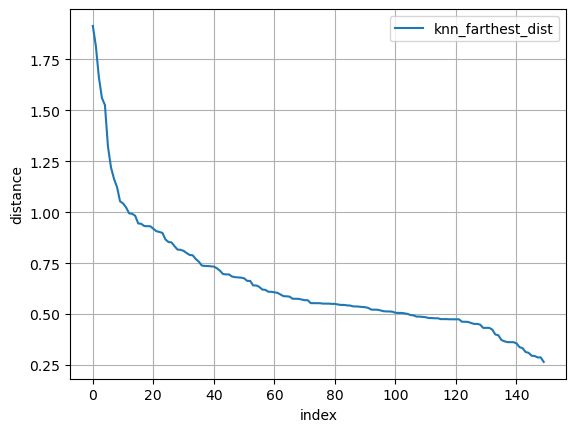

In [8]:
# Plot the k-distance graph
df.sort_values('knn_farthest_dist', ascending=False).reset_index()[['knn_farthest_dist']].plot()  # Sort by k-distance (high to low), reset index, and plot
plt.xlabel('index')  # Label x-axis as 'index' (represents sorted data points)
plt.ylabel('distance')  # Label y-axis as 'distance' (k-th nearest neighbor distance)
plt.grid(True)  # Add grid lines to the plot for better readability
plt.show()  # Display the plot

In [9]:
# DBSCAN using chosen params
km = DBSCAN(eps=0.7, min_samples=min_samples)
df['cluster'] = km.fit_predict(df[['sepal length', 'sepal width', 'petal length', 'petal width']])
df.cluster.value_counts()

cluster
 1    86
 0    47
-1    17
Name: count, dtype: int64